In [3]:
!pip -q install -U gdown dominate visdom "pillow>=10,<12" scikit-image scikit-learn

import csv
import os
from pathlib import Path

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from skimage.color import deltaE_ciede2000, rgb2lab
from sklearn.metrics import roc_auc_score



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from pathlib import Path

BASE = Path(r"C:\Users\T-GAMER\trabalhos cic\projeto ia 2\DeteccaoAnomalia\content\data\Projeto_Ramularia")
print("Existe BASE?", BASE.exists(), BASE)

for dname in ["Healthy_Train50", "Healthy_Test50", "Disease_Test100"]:
    d = BASE / dname
    n = len(list(d.glob("*.jpg"))) + len(list(d.glob("*.png"))) if d.exists() else 0
    print(f"{dname}: {n} imagens", "(OK)" if d.exists() else "(NÃO ENCONTRADO)")


Existe BASE? True C:\Users\T-GAMER\trabalhos cic\projeto ia 2\DeteccaoAnomalia\content\data\Projeto_Ramularia
Healthy_Train50: 50 imagens (OK)
Healthy_Test50: 50 imagens (OK)
Disease_Test100: 100 imagens (OK)


In [19]:
BASE = Path(r"C:\Users\T-GAMER\trabalhos cic\projeto ia 2\DeteccaoAnomalia\content\data\Projeto_Ramularia")
print("Existe BASE?", BASE.exists(), BASE)

for dname in ["Healthy_Train50", "Healthy_Test50", "Disease_Test100"]:
    d = BASE / dname
    n = len(list(d.glob("*.jpg"))) + len(list(d.glob("*.png"))) if d.exists() else 0
    print(f"{dname}: {n} imagens", "(OK)" if d.exists() else "(NÃO ENCONTRADO)")


Existe BASE? True C:\Users\T-GAMER\trabalhos cic\projeto ia 2\DeteccaoAnomalia\content\data\Projeto_Ramularia
Healthy_Train50: 50 imagens (OK)
Healthy_Test50: 50 imagens (OK)
Disease_Test100: 100 imagens (OK)


In [4]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd /content/pytorch-CycleGAN-and-pix2pix

!python train.py -h | head -n 25
!python test.py -h | head -n 35


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2619, done.
remote: Total 2619 (delta 0), reused 0 (delta 0), pack-reused 2619 (from 1)
Receiving objects: 100% (2619/2619), 8.24 MiB | 27.93 MiB/s, done.
Resolving deltas: 100% (1654/1654), done.
/content/pytorch-CycleGAN-and-pix2pix
usage: train.py [-h] --dataroot DATAROOT [--name NAME]
                [--checkpoints_dir CHECKPOINTS_DIR] [--model MODEL]
                [--input_nc INPUT_NC] [--output_nc OUTPUT_NC] [--ngf NGF]
                [--ndf NDF] [--netD NETD] [--netG NETG]
                [--n_layers_D N_LAYERS_D] [--norm NORM]
                [--init_type INIT_TYPE] [--init_gain INIT_GAIN] [--no_dropout]
                [--dataset_mode DATASET_MODE] [--direction DIRECTION]
                [--serial_batches] [--num_threads NUM_THREADS]
                [--batch_size BATCH_SIZE] [--load_size LOAD_SIZE]
                [--crop_size CROP_SIZE] [--max_dataset_size MAX_DATASET_SIZE]
                [--prepr

In [20]:
OUT = Path("C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/content/data/ramularia_colorrec")  
AB_TRAIN = OUT / "AB" / "train"
AB_TEST  = OUT / "AB" / "test"
AB_TRAIN.mkdir(parents=True, exist_ok=True)
AB_TEST.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (256, 256)

def make_ab_from_color(color_img: Image.Image) -> Image.Image:
    """Cria o par (A=cinza, B=colorido) concatenado horizontalmente."""
    B = color_img.convert("RGB").resize(IMG_SIZE, Image.BICUBIC)
    A = B.convert("L").convert("RGB")
    AB = Image.new("RGB", (IMG_SIZE[0] * 2, IMG_SIZE[1]))
    AB.paste(A, (0, 0))
    AB.paste(B, (IMG_SIZE[0], 0))
    return AB

def iter_images(folder: Path):
    exts = ["*.jpg", "*.jpeg", "*.png"]
    files = []
    for e in exts:
        files += list(folder.glob(e))
    return sorted(files)

# Criar pares para treino
train_files = iter_images(BASE / "Healthy_Train50")
print("Treino (saudável):", len(train_files))

for p in train_files:
    img = Image.open(p)
    ab = make_ab_from_color(img)
    ab.save(AB_TRAIN / (p.stem + ".jpg"), quality=95)

# Criar pares para teste (saudáveis + doentes)
test_h = iter_images(BASE / "Healthy_Test50")
test_d = iter_images(BASE / "Disease_Test100")
print("Teste saudável:", len(test_h))
print("Teste doente:", len(test_d))

rows = []
def add_test(files, label, prefix):
    for p in files:
        img = Image.open(p)
        ab = make_ab_from_color(img)
        out_name = f"{prefix}_{p.stem}.jpg"
        ab.save(AB_TEST / out_name, quality=95)
        rows.append({"file": out_name, "label": label, "src": str(p)})

add_test(test_h, 0, "H")  # 0 = saudável
add_test(test_d, 1, "D")  # 1 = doente

print("AB/train:", len(list(AB_TRAIN.glob('*.jpg'))))
print("AB/test:", len(list(AB_TEST.glob('*.jpg'))))


Treino (saudável): 50
Teste saudável: 50
Teste doente: 100
AB/train: 50
AB/test: 150


In [6]:
%cd /content/pytorch-CycleGAN-and-pix2pix

!CUDA_VISIBLE_DEVICES=0 python train.py \
  --dataroot /content/data/ramularia_colorrec/AB \
  --name ramularia_colorrec_pix2pix \
  --model pix2pix \
  --dataset_mode aligned \
  --direction AtoB \
  --netG unet_256 \
  --input_nc 3 --output_nc 3 \
  --load_size 286 --crop_size 256 \
  --batch_size 1 \
  --n_epochs 50 --n_epochs_decay 50 \
  --no_html

/content/pytorch-CycleGAN-and-pix2pix
----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/data/ramularia_colorrec/AB	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
             display_freq: 400                           
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1                             
                 gan_mode: vanilla                       
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3 

In [7]:
!CUDA_VISIBLE_DEVICES=0 python test.py \
  --dataroot /content/data/ramularia_colorrec/AB \
  --name ramularia_colorrec_pix2pix \
  --model pix2pix \
  --dataset_mode aligned \
  --direction AtoB \
  --netG unet_256 \
  --epoch latest

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/data/ramularia_colorrec/AB	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                             	[default: 0]
                load_size: 256        

In [8]:

RESULTS_DIR = Path("/content/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images")
MANIFEST = Path("/content/data/ramularia_colorrec/test_manifest.csv")

print("RESULTS_DIR existe?", RESULTS_DIR.exists(), RESULTS_DIR)
print("MANIFEST existe?", MANIFEST.exists(), MANIFEST)

df = pd.read_csv(MANIFEST)

def load_rgb(path: Path) -> np.ndarray:
    img = Image.open(path).convert("RGB")
    arr = np.asarray(img).astype(np.float32) / 255.0
    return arr

scores = []
missing = 0

for _, row in df.iterrows():
    base = Path(row["file"]).stem
    real_b = RESULTS_DIR / f"{base}_real_B.png"
    fake_b = RESULTS_DIR / f"{base}_fake_B.png"
    if not real_b.exists() or not fake_b.exists():
        missing += 1
        continue

    rb = load_rgb(real_b)
    fb = load_rgb(fake_b)

    lab_rb = rgb2lab(rb)
    lab_fb = rgb2lab(fb)
    de = deltaE_ciede2000(lab_rb, lab_fb)  

    score_sum = float(np.sum(de))
    score_mean = float(np.mean(de))

    scores.append((row["file"], int(row["label"]), score_sum, score_mean))

print("Arquivos faltando no results:", missing)

out = pd.DataFrame(scores, columns=["file", "label", "score_sum", "score_mean"])
out = out.merge(df, on=["file", "label"], how="left")

if out["label"].nunique() == 2 and len(out) > 1:
    auc = roc_auc_score(out["label"], out["score_sum"])
    print("AUC (score_sum):", auc)

out = out.sort_values("score_sum", ascending=False)
out.head(15)


RESULTS_DIR existe? True /content/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images
MANIFEST existe? True /content/data/ramularia_colorrec/test_manifest.csv
Arquivos faltando no results: 100


file  label      score_sum  score_mean  \
39  D_a1017-1020 ad_1.jpg      1  245256.781250    3.742321   
26  D_a1008-1013 ad_4.jpg      1  199621.625000    3.045984   
11  D_a1004-1007 ad_0.jpg      1  195181.062500    2.978227   
22  D_a1008-1013 ad_0.jpg      1  188766.453125    2.880347   
33  D_a1014-1016 ad_2.jpg      1  186302.093750    2.842744   
3   D_a1001-1003 ad_0.jpg      1  181473.500000    2.769066   
14  D_a1004-1007 ad_3.jpg      1  177021.281250    2.701130   
4   D_a1001-1003 ad_1.jpg      1  158132.625000    2.412912   
40  D_a1017-1020 ad_2.jpg      1  155704.125000    2.375856   
38  D_a1017-1020 ad_0.jpg      1  152237.687500    2.322963   
34  D_a1017-1020 ab_0.jpg      1  151655.937500    2.314086   
5   D_a1001-1003 ad_2.jpg      1  150403.937500    2.294982   
12  D_a1004-1007 ad_1.jpg      1  149744.453125    2.284919   
7   D_a1004-1007 ab_1.jpg      1  149154.015625    2.275910   
32  D_a1014-1016 ad_1.jpg      1  146488.921875    2.235244   

                                                  src  
39  /content/data/Projeto_Ramularia/Disease_Test10...  
26  /content/data/Projeto_Ramularia/Disease_Test10...  
11  /content/data/Projeto_Ramularia/Disease_Test10...  
22  /content/data/Projeto_Ramularia/Disease_Test10...  
33  /content/data/Projeto_Ramularia/Disease_Test10...  
3   /content/data/Projeto_Ramularia/Disease_Test10...  
14  /content/data/Projeto_Ramularia/Disease_Test10...  
4   /content/data/Projeto_Ramularia/Disease_Test10...  
40  /content/data/Projeto_Ramularia/Disease_Test10...  
38  /content/data/Projeto_Ramularia/Disease_Test10...  
34  /content/data/Projeto_Ramularia/Disease_Test10...  
5   /content/data/Projeto_Ramularia/Disease_Test10...  
12  /content/data/Projeto_Ramularia/Disease_Test10...  
7   /content/data/Projeto_Ramularia/Disease_Test10...  
32  /content/data/Projeto_Ramularia/Disease_Test10...

In [9]:
!ls -1 /content/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images | wc -l
!ls -1 /content/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images | head -n 30
!python test.py -h | sed -n '1,120p'


150
D_a1001-1003 ab_0_fake_B.png
D_a1001-1003 ab_0_real_A.png
D_a1001-1003 ab_0_real_B.png
D_a1001-1003 ab_1_fake_B.png
D_a1001-1003 ab_1_real_A.png
D_a1001-1003 ab_1_real_B.png
D_a1001-1003 ab_2_fake_B.png
D_a1001-1003 ab_2_real_A.png
D_a1001-1003 ab_2_real_B.png
D_a1001-1003 ad_0_fake_B.png
D_a1001-1003 ad_0_real_A.png
D_a1001-1003 ad_0_real_B.png
D_a1001-1003 ad_1_fake_B.png
D_a1001-1003 ad_1_real_A.png
D_a1001-1003 ad_1_real_B.png
D_a1001-1003 ad_2_fake_B.png
D_a1001-1003 ad_2_real_A.png
D_a1001-1003 ad_2_real_B.png
D_a1004-1007 ab_0_fake_B.png
D_a1004-1007 ab_0_real_A.png
D_a1004-1007 ab_0_real_B.png
D_a1004-1007 ab_1_fake_B.png
D_a1004-1007 ab_1_real_A.png
D_a1004-1007 ab_1_real_B.png
D_a1004-1007 ab_2_fake_B.png
D_a1004-1007 ab_2_real_A.png
D_a1004-1007 ab_2_real_B.png
D_a1004-1007 ab_3_fake_B.png
D_a1004-1007 ab_3_real_A.png
D_a1004-1007 ab_3_real_B.png
usage: test.py [-h] --dataroot DATAROOT [--name NAME]
               [--checkpoints_dir CHECKPOINTS_DIR] [--model MODEL]
     

Reconstruções disponíveis: 50


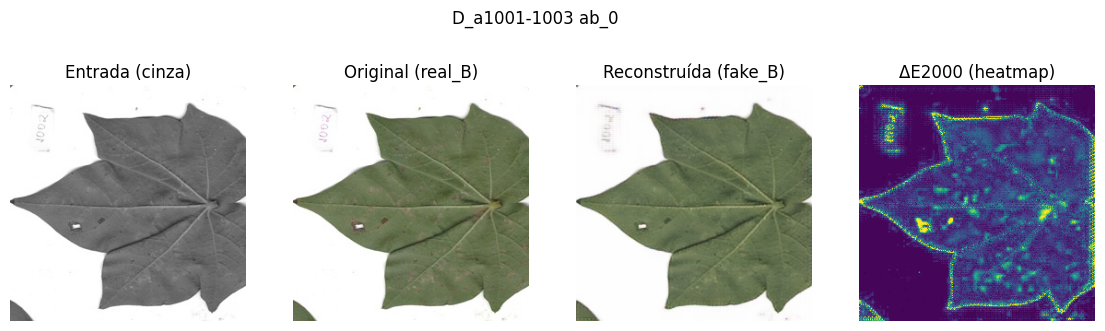

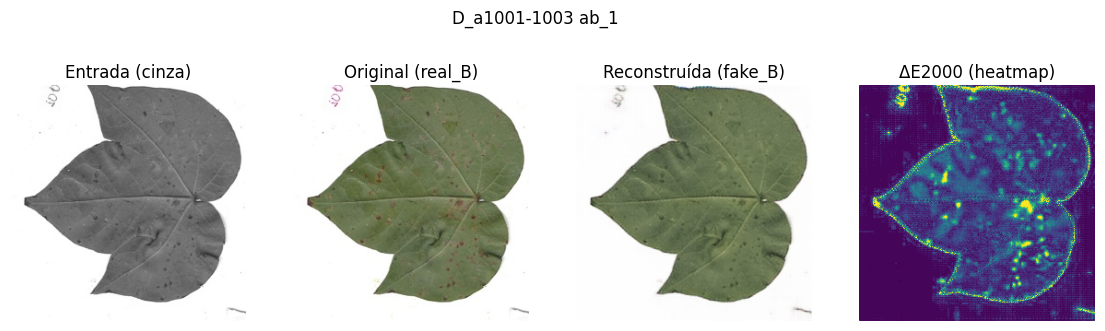

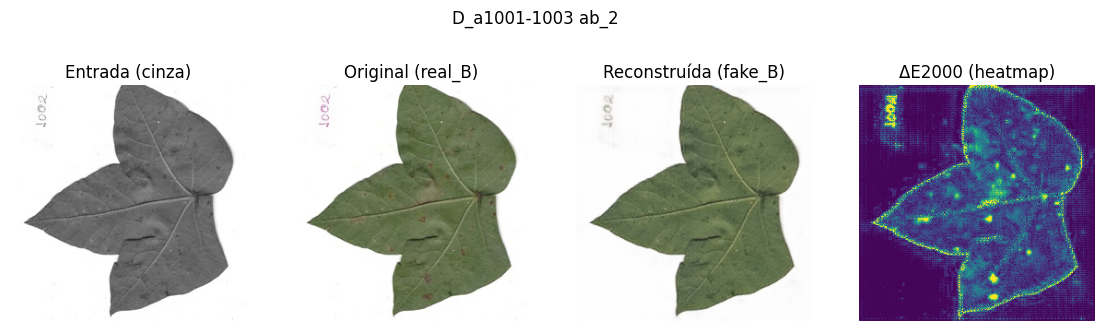

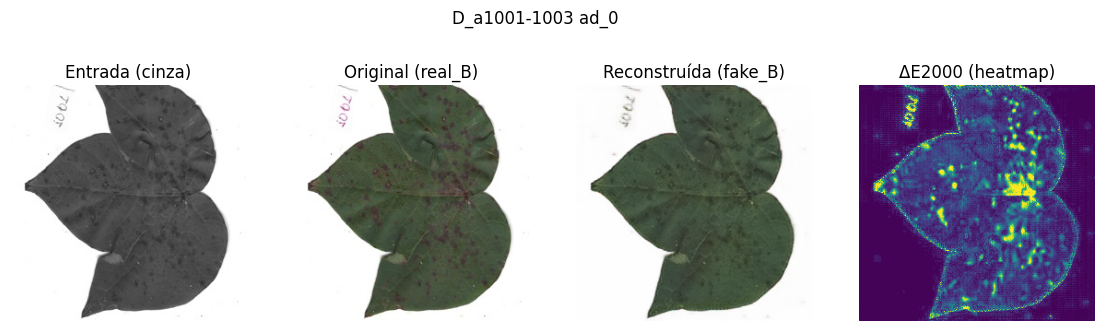

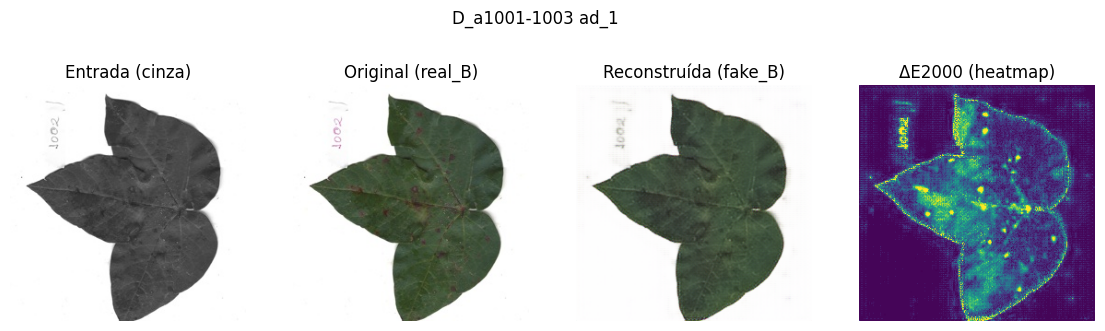

In [10]:

RESULTS_DIR = Path("/content/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images")

def load_rgb_uint8(path: Path):
    return np.asarray(Image.open(path).convert("RGB"))

def show_case(base: str, title: str = ""):
    real_b = RESULTS_DIR / f"{base}_real_B.png"
    fake_b = RESULTS_DIR / f"{base}_fake_B.png"
    real_a = RESULTS_DIR / f"{base}_real_A.png"
    if not real_b.exists() or not fake_b.exists():
        print("Não achei:", base)
        return

    rb_u8 = load_rgb_uint8(real_b)
    fb_u8 = load_rgb_uint8(fake_b)
    ra_u8 = load_rgb_uint8(real_a) if real_a.exists() else None

    rb = rb_u8.astype(np.float32) / 255.0
    fb = fb_u8.astype(np.float32) / 255.0
    de = deltaE_ciede2000(rgb2lab(rb), rgb2lab(fb))


    de_norm = de / (np.percentile(de, 99) + 1e-6)
    de_norm = np.clip(de_norm, 0, 1)

    plt.figure(figsize=(14,4))
    if title:
        plt.suptitle(title)

    ax1 = plt.subplot(1,4,1)
    plt.title("Entrada (cinza)")
    if ra_u8 is not None:
        plt.imshow(ra_u8)
    else:
        plt.imshow(rb_u8)
    plt.axis("off")

    ax2 = plt.subplot(1,4,2)
    plt.title("Original (real_B)")
    plt.imshow(rb_u8)
    plt.axis("off")

    ax3 = plt.subplot(1,4,3)
    plt.title("Reconstruída (fake_B)")
    plt.imshow(fb_u8)
    plt.axis("off")

    ax4 = plt.subplot(1,4,4)
    plt.title("ΔE2000 (heatmap)")
    plt.imshow(de_norm)
    plt.axis("off")

    plt.show()

pngs = sorted(RESULTS_DIR.glob("*_fake_B.png"))
print("Reconstruções disponíveis:", len(pngs))
for p in pngs[:5]:
    base = p.name.replace("_fake_B.png","")
    show_case(base, title=base)


INFERÊNCIA COM IMAGEM QUE Não PERTENCE AO DATASET

In [11]:
%cd /content/pytorch-CycleGAN-and-pix2pix
!grep -E "netG:|norm:|input_nc:|output_nc:|ngf:|no_dropout:" checkpoints/ramularia_colorrec_pix2pix/train_opt.txt
!cp -f checkpoints/ramularia_colorrec_pix2pix/train_opt.txt checkpoints/ramularia_colorrec_pix2pix/opt.txt

/content/pytorch-CycleGAN-and-pix2pix
                 input_nc: 3                             
                     netG: unet_256                      
                      ngf: 64                            
               no_dropout: False                         
                     norm: batch                         
                output_nc: 3                             


In [12]:
!mkdir -p /content/inferencia_single/single_in
!ls -lah /content/inferencia_single
!ls -lah /content/inferencia_single/single_in


total 12K
drwxr-xr-x 3 root root 4.0K Nov 30 16:27 .
drwxr-xr-x 1 root root 4.0K Nov 30 16:27 ..
drwxr-xr-x 2 root root 4.0K Nov 30 16:27 single_in
total 8.0K
drwxr-xr-x 2 root root 4.0K Nov 30 16:27 .
drwxr-xr-x 3 root root 4.0K Nov 30 16:27 ..


In [13]:
URL="https://drive.google.com/file/d/1C2RHzVwYiEN16f4PtvskRVLp4t1CBkLQ/view?usp=sharing"

base = Path("/content/inferencia_single")
single_in = base / "single_in"
single_in.mkdir(parents=True, exist_ok=True)

orig_path = base / "orig.jpg"
gdown.download(URL, str(orig_path), quiet=False, fuzzy=True)

img = Image.open(orig_path).convert("RGB")
img_gray = ImageOps.grayscale(img).convert("RGB")


input_path = single_in / "input.jpg"
img_gray.save(input_path, quality=95)

print("Existe pasta single_in?", single_in.exists())
print("Arquivos em single_in:", [p.name for p in single_in.glob("*")])


Downloading...
From: https://drive.google.com/uc?id=1C2RHzVwYiEN16f4PtvskRVLp4t1CBkLQ
To: /content/inferencia_single/orig.jpg
100%|██████████| 60.6k/60.6k [00:00<00:00, 54.2MB/s]

Existe pasta single_in? True
Arquivos em single_in: ['input.jpg']


In [14]:

URL = "https://drive.google.com/file/d/1C2RHzVwYiEN16f4PtvskRVLp4t1CBkLQ/view?usp=sharing"


base = Path("/content/inferencia_single")
single_in = base / "single_in"
single_in.mkdir(parents=True, exist_ok=True)

orig_path = base / "orig.jpg"
gdown.download(URL, str(orig_path), quiet=False, fuzzy=True)

img = Image.open(orig_path).convert("RGB")
img_gray = ImageOps.grayscale(img).convert("RGB")

input_path = single_in / "input.jpg"
img_gray.save(input_path, quality=95)

print("OK:", orig_path, input_path)


%cd /content/pytorch-CycleGAN-and-pix2pix

!python test.py \
  --dataroot /content/inferencia_single/single_in \
  --name ramularia_colorrec_pix2pix \
  --checkpoints_dir /content/pytorch-CycleGAN-and-pix2pix/checkpoints \
  --model test \
  --dataset_mode single \
  --epoch latest \
  --num_test 1 \
  --results_dir /content/inferencia_single/results \
  --netG unet_256 \
  --norm batch \
  --input_nc 3 \
  --output_nc 3 \
  --ngf 64 \
  --preprocess resize \
  --load_size 256 \
  --crop_size 256 \
  --no_flip \
  


Downloading...
From: https://drive.google.com/uc?id=1C2RHzVwYiEN16f4PtvskRVLp4t1CBkLQ
To: /content/inferencia_single/orig.jpg
100%|██████████| 60.6k/60.6k [00:00<00:00, 53.2MB/s]


OK: /content/inferencia_single/orig.jpg /content/inferencia_single/single_in/input.jpg
/content/pytorch-CycleGAN-and-pix2pix
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/pytorch-CycleGAN-and-pix2pix/checkpoints	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /content/inferencia_single/single_in	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
             

Arquivo real: /content/inferencia_single/results/ramularia_colorrec_pix2pix/test_latest/images/input_real.png
Arquivo fake: /content/inferencia_single/results/ramularia_colorrec_pix2pix/test_latest/images/input_fake.png


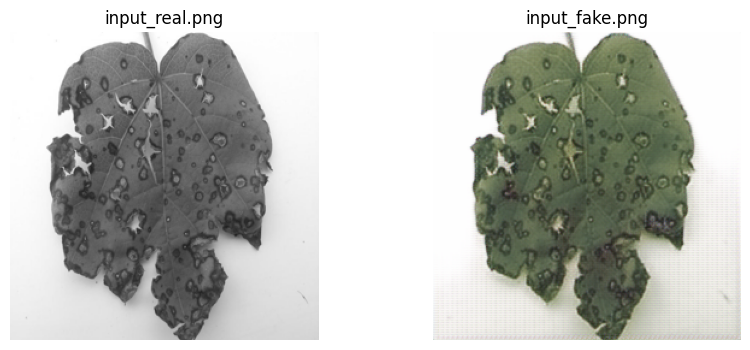

In [15]:
img_dir = Path("/content/inferencia_single/results/ramularia_colorrec_pix2pix/test_latest/images")

fake = next((p for p in img_dir.glob("*") if "fake" in p.name.lower()), None)
real = next((p for p in img_dir.glob("*") if "real" in p.name.lower()), None)

print("Arquivo real:", real)
print("Arquivo fake:", fake)

paths = [p for p in [real, fake] if p is not None]

plt.figure(figsize=(10, 4))
for i, p in enumerate(paths, 1):
    plt.subplot(1, len(paths), i)
    plt.imshow(Image.open(p))
    plt.axis("off")
    plt.title(p.name)
plt.show()



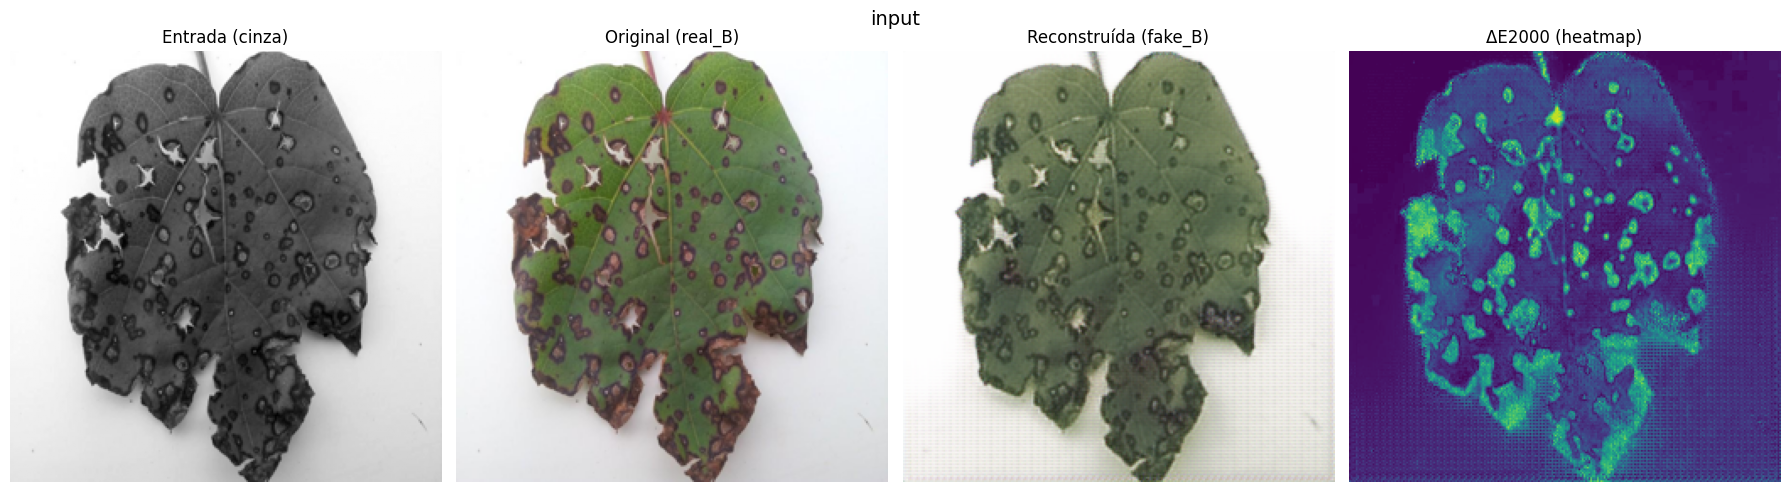

Entrada: /content/inferencia_single/single_in/input.jpg
Original: /content/inferencia_single/orig.jpg
Reconstruída: /content/inferencia_single/results/ramularia_colorrec_pix2pix/test_latest/images/input_fake.png
ΔE2000 média: 7.3778181076049805


In [16]:

orig_path = Path("/content/inferencia_single/orig.jpg")                 
gray_path = Path("/content/inferencia_single/single_in/input.jpg")     

img_dir = Path("/content/inferencia_single/results/ramularia_colorrec_pix2pix/test_latest/images")
assert img_dir.exists(), f"Pasta de imagens não existe: {img_dir}"

fake_path = next((p for p in sorted(img_dir.glob("*")) if "fake" in p.name.lower()), None)
assert fake_path is not None, f"Não encontrei arquivo fake em: {img_dir}"

orig = Image.open(orig_path).convert("RGB")
gray = Image.open(gray_path).convert("RGB")
fake = Image.open(fake_path).convert("RGB")

W, H = fake.size
orig_rs = orig.resize((W, H))
gray_rs = gray.resize((W, H))

real_np = np.asarray(orig_rs, dtype=np.float32) / 255.0
fake_np = np.asarray(fake,    dtype=np.float32) / 255.0

de = deltaE_ciede2000(rgb2lab(real_np), rgb2lab(fake_np))  

title_id = fake_path.stem.replace("_fake", "").replace("_fake_B", "").replace("_fake_A", "")

plt.figure(figsize=(18, 5))
plt.suptitle(title_id, fontsize=14)

plt.subplot(1, 4, 1)
plt.imshow(np.asarray(gray_rs.convert("L")), cmap="gray")
plt.title("Entrada (cinza)")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(orig_rs)
plt.title("Original (real_B)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(fake)
plt.title("Reconstruída (fake_B)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(de)  
plt.title("ΔE2000 (heatmap)")
plt.axis("off")

plt.tight_layout()
plt.show()

print("Entrada:", gray_path)
print("Original:", orig_path)
print("Reconstruída:", fake_path)
print("ΔE2000 média:", float(de.mean()))



MÉTRICAS

In [17]:


def load_rgb(p: Path) -> np.ndarray:
    """Carrega imagem RGB como numpy uint8 (H, W, 3)."""
    return np.asarray(Image.open(p).convert("RGB"))

def resize_to(img: np.ndarray, target_hw: tuple[int, int]) -> np.ndarray:
    """Redimensiona img para (H, W) do target."""
    H, W = target_hw
    return np.asarray(Image.fromarray(img).resize((W, H)))

def leaf_mask_from_rgb(rgb: np.ndarray, white_thr: int = 240) -> np.ndarray:
    
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    mask = (r < white_thr) | (g < white_thr) | (b < white_thr)
    return mask

def de2000_map(real_rgb_u8: np.ndarray, fake_rgb_u8: np.ndarray) -> np.ndarray:
    
    real = real_rgb_u8.astype(np.float32) / 255.0
    fake = fake_rgb_u8.astype(np.float32) / 255.0
    return deltaE_ciede2000(rgb2lab(real), rgb2lab(fake))

def metric_top_p_mean(de_map: np.ndarray, leaf_mask: np.ndarray, top_p: float = 0.02) -> float:
    
    vals = de_map[leaf_mask]
    if vals.size == 0:
        return 0.0
    k = max(1, int(np.ceil(top_p * vals.size)))
    topk = np.partition(vals, -k)[-k:]
    return float(topk.mean())

def metric_concentration_top_q_energy(de_map: np.ndarray, leaf_mask: np.ndarray, top_q: float = 0.01) -> float:
    
    vals = de_map[leaf_mask]
    if vals.size == 0:
        return 0.0
    k = max(1, int(np.ceil(top_q * vals.size)))
    topk = np.partition(vals, -k)[-k:]
    denom = float(vals.sum()) + 1e-12
    return float(topk.sum() / denom)


Arquivo fake: input_fake.png
Métrica 1, detecção por imagem, Top2% mean ΔE2000: 29.460872650146484
Métrica 2, proxy de localização, Top1% energy fraction: 0.03360942751169205


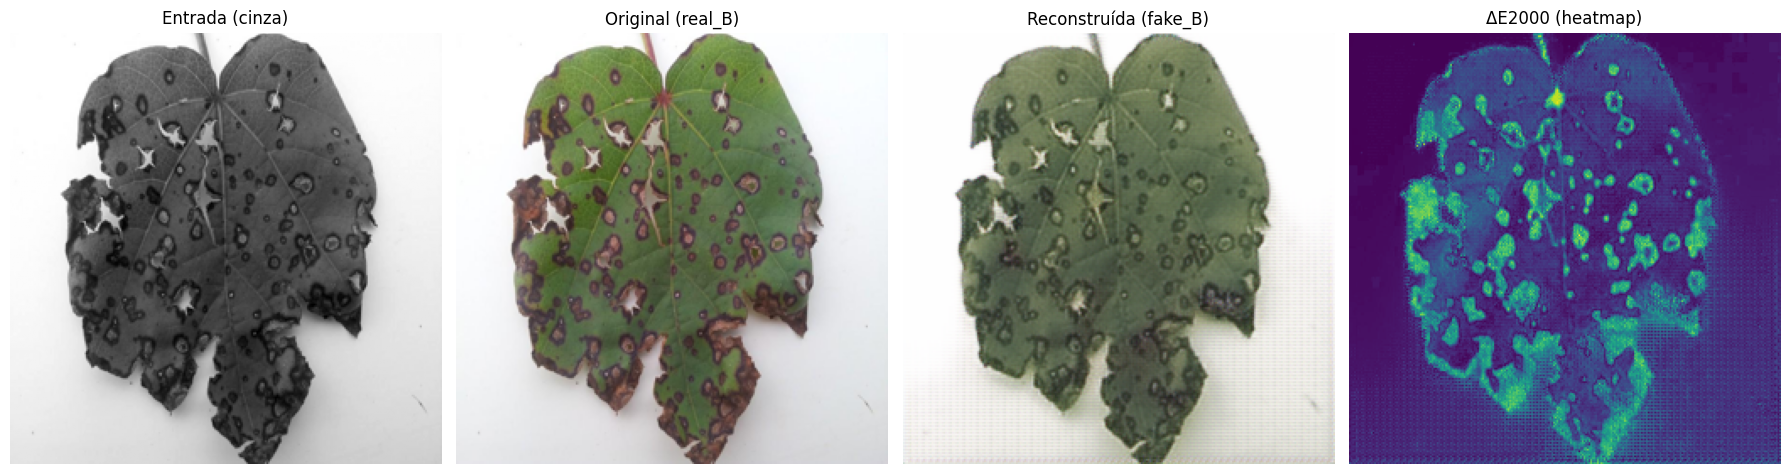

In [18]:

base = Path("/content/inferencia_single")
orig_path = base / "orig.jpg"
gray_path = base / "single_in" / "input.jpg"

img_dir = base / "results" / "ramularia_colorrec_pix2pix" / "test_latest" / "images"
fake_path = next((p for p in sorted(img_dir.glob("*")) if "fake" in p.name.lower()), None)
if fake_path is None:
    raise FileNotFoundError(f"Não encontrei arquivo fake em {img_dir}")


orig = load_rgb(orig_path)
gray = load_rgb(gray_path)
fake = load_rgb(fake_path)


H, W = fake.shape[:2]
orig_rs = resize_to(orig, (H, W))
gray_rs = resize_to(gray, (H, W))


leaf_mask = leaf_mask_from_rgb(orig_rs, white_thr=240)


de = de2000_map(orig_rs, fake)
score_detect = metric_top_p_mean(de, leaf_mask, top_p=0.02)           
score_loc = metric_concentration_top_q_energy(de, leaf_mask, top_q=0.01)  

print("Arquivo fake:", fake_path.name)
print("Métrica 1, detecção por imagem, Top2% mean ΔE2000:", score_detect)
print("Métrica 2, proxy de localização, Top1% energy fraction:", score_loc)

plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(np.asarray(Image.fromarray(gray_rs).convert("L")), cmap="gray")
plt.title("Entrada (cinza)")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(orig_rs)
plt.title("Original (real_B)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(fake)
plt.title("Reconstruída (fake_B)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(de)
plt.title("ΔE2000 (heatmap)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [21]:
def find_files(root="/content", suffix=".pth", limit=200):
    hits = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(suffix):
                hits.append(os.path.join(dirpath, fn))
                if len(hits) >= limit:
                    return hits
    return hits

hits = find_files("/content", ".pth", limit=300)

print("Total .pth encontrados:", len(hits))
for p in hits:
    print(p)


Total .pth encontrados: 43
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix2pix/85_net_G.pth
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix2pix/15_net_G.pth
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix2pix/5_net_D.pth
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix2pix/50_net_G.pth
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix2pix/80_net_G.pth
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix2pix/30_net_D.pth
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix2pix/100_net_G.pth
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix2pix/75_net_G.pth
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix2pix/100_net_D.pth
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix2pix/35_net_G.pth
/content/pytorch-CycleGAN-and-pix2pix/checkpoints/ramularia_colorrec_pix

In [13]:
%cd "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/pytorch-CycleGAN-and-pix2pix"

C:\Users\T-GAMER\trabalhos cic\projeto ia 2\DeteccaoAnomalia\pytorch-CycleGAN-and-pix2pix


In [21]:
!python train.py \
  --dataroot "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/content/data/ramularia_colorrec/AB" \
  --name ramularia_colorrec_pix2pix \
  --model pix2pix \
  --dataset_mode aligned \
  --direction AtoB \
  --netG unet_256 \
  --input_nc 3 --output_nc 3 \
  --load_size 286 --crop_size 256 \
  --batch_size 1 \
  --n_epochs 50 --n_epochs_decay 50 \
  --no_html


----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/content/data/ramularia_colorrec/AB	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
             display_freq: 400                           
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1                             
                 gan_mode: vanilla                       
                init_gain: 0.02                          
                init_type: normal                        
       

In [23]:
!python test.py \
  --dataroot "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/content/data/ramularia_colorrec/AB" \
  --name ramularia_colorrec_pix2pix \
  --model pix2pix \
  --dataset_mode aligned \
  --direction AtoB \
  --netG unet_256 \
  --input_nc 3 --output_nc 3 \
  --load_size 286 --crop_size 256 \
  --batch_size 1 \
  --epoch latest \
  --num_test 150


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/content/data/ramularia_colorrec/AB	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                     

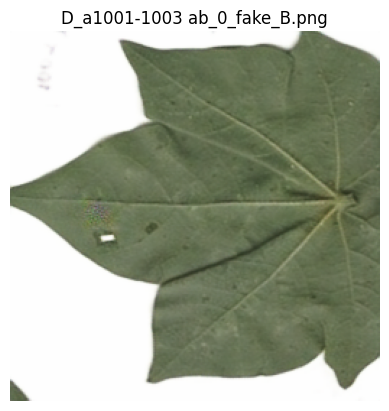

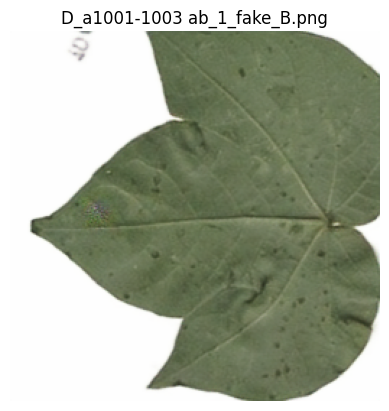

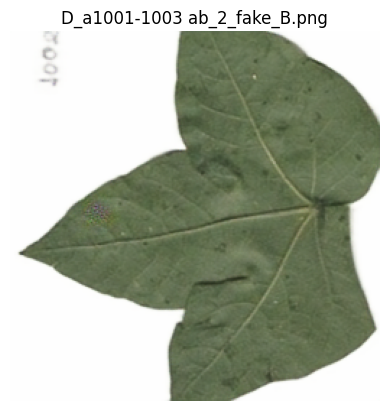

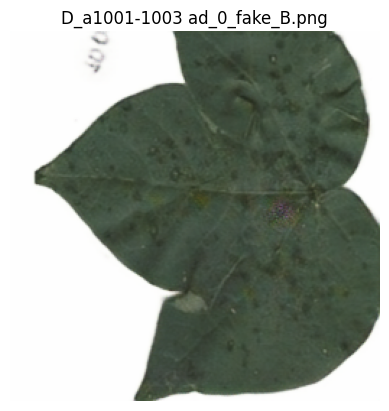

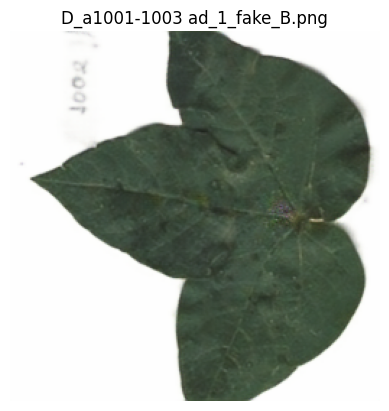

In [24]:
import matplotlib.pyplot as plt
import os
from PIL import Image

results_dir = "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images"

files = [f for f in os.listdir(results_dir) if f.endswith("_fake_B.png")][:5]

for f in files:
    img = Image.open(os.path.join(results_dir, f))
    plt.figure()
    plt.imshow(img)
    plt.title(f)
    plt.axis("off")
    plt.show()


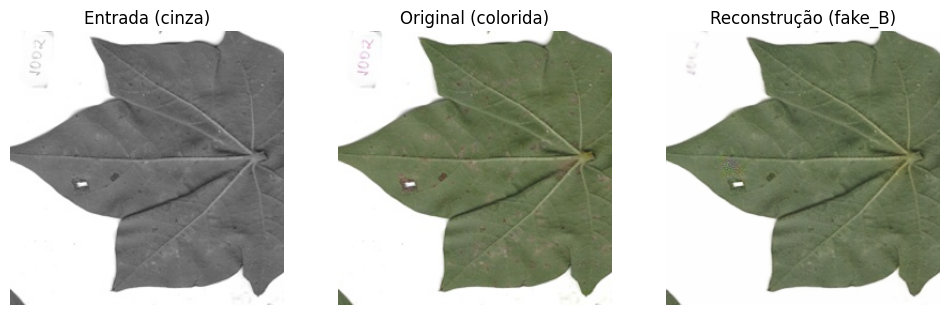

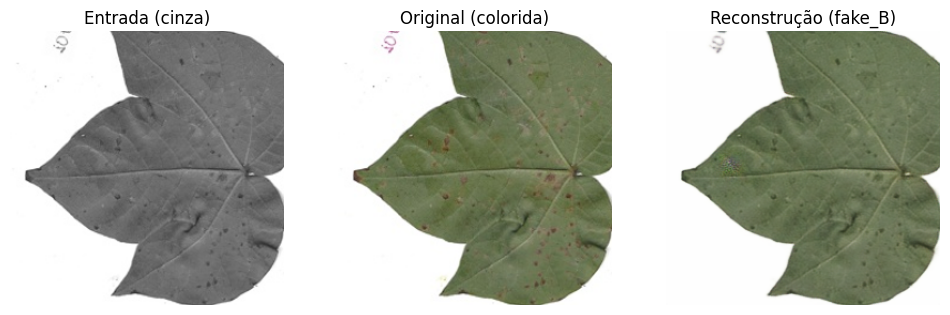

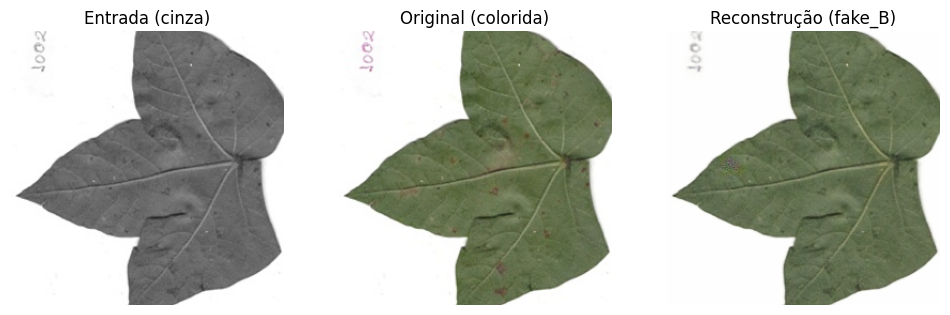

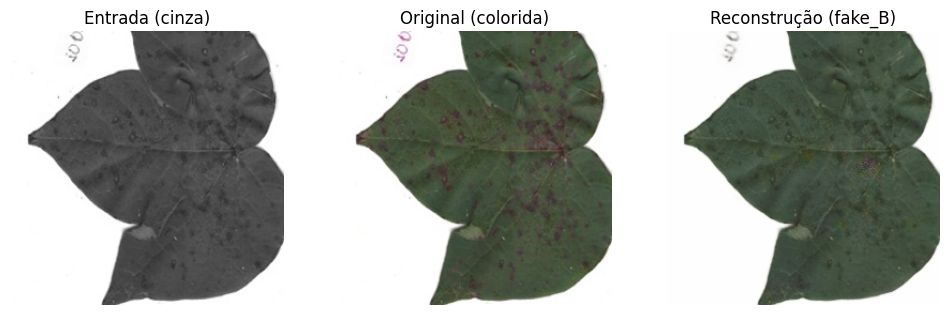

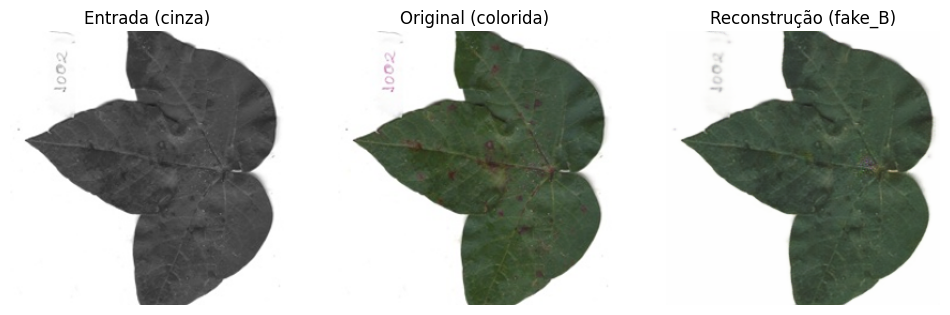

In [26]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Caminho da pasta de resultados
results_dir = "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images"

# Pegar alguns exemplos de reconstrução
files = [f for f in os.listdir(results_dir) if f.endswith("_fake_B.png")][:5]

for f in files:
    base = f.replace("_fake_B.png", "")
    
    # Procurar os arquivos relacionados
    candidates = [fname for fname in os.listdir(results_dir) if fname.startswith(base)]
    real_A = [c for c in candidates if c.endswith("_real_A.png")]
    real_B = [c for c in candidates if c.endswith("_real_B.png")]
    
    # Abrir imagens
    img_F = Image.open(os.path.join(results_dir, f))
    img_A = Image.open(os.path.join(results_dir, real_A[0])) if real_A else None
    img_B = Image.open(os.path.join(results_dir, real_B[0])) if real_B else None

    # Mostrar lado a lado
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    if img_A: axs[0].imshow(img_A); axs[0].set_title("Entrada (cinza)")
    else: axs[0].text(0.5, 0.5, "real_A não encontrado", ha="center")
    if img_B: axs[1].imshow(img_B); axs[1].set_title("Original (colorida)")
    else: axs[1].text(0.5, 0.5, "real_B não encontrado", ha="center")
    axs[2].imshow(img_F); axs[2].set_title("Reconstrução (fake_B)")
    for ax in axs: ax.axis("off")
    plt.show()


In [28]:
import os
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

results_dir = "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images"


def load_img(path):
    return np.array(Image.open(path).convert("RGB"))

files = [f for f in os.listdir(results_dir) if f.endswith("_fake_B.png")]
ssim_vals, psnr_vals = [], []

for f in files:
    base = f.replace("_fake_B.png", "")
    real_B = os.path.join(results_dir, base + "_real_B.png")
    fake_B = os.path.join(results_dir, f)
    if not os.path.exists(real_B): 
        continue
    img_real = load_img(real_B)
    img_fake = load_img(fake_B)
    s = ssim(img_real, img_fake, channel_axis=2, data_range=255)
    p = psnr(img_real, img_fake, data_range=255)
    ssim_vals.append(s); psnr_vals.append(p)

print("SSIM média:", np.mean(ssim_vals))
print("PSNR média:", np.mean(psnr_vals))


SSIM média: 0.9683999166296049
PSNR média: 37.17668271615641


ΔE médio (saudáveis): 2.419087224006653
ΔE médio (doentes): 3.444127945899963


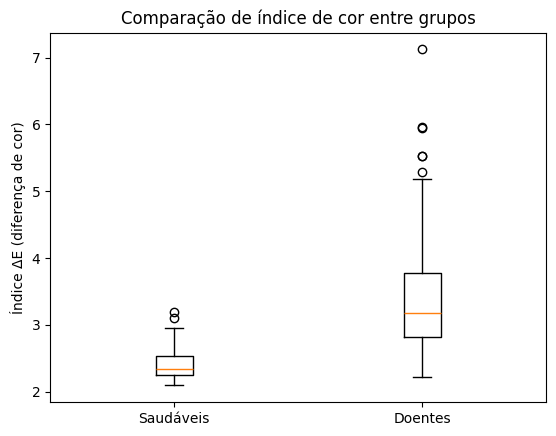

In [35]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Pasta de resultados do Pix2pix
results_dir = "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images"

def deltaE_score(img_real_rgb, img_fake_rgb):
    # Converter para LAB
    real_lab = cv2.cvtColor(img_real_rgb, cv2.COLOR_RGB2LAB)
    fake_lab = cv2.cvtColor(img_fake_rgb, cv2.COLOR_RGB2LAB)
    diff = real_lab.astype(np.float32) - fake_lab.astype(np.float32)
    de = np.sqrt(np.sum(diff**2, axis=2))
    return float(np.mean(de))  # score médio

def load_img(path):
    return np.array(Image.open(path).convert("RGB"))

scores_healthy, scores_disease = [], []

# Iterar sobre reconstruções
files = [f for f in os.listdir(results_dir) if f.endswith("_fake_B.png")]
for f in files:
    base = f.replace("_fake_B.png", "")
    real_B = os.path.join(results_dir, base + "_real_B.png")
    fake_B = os.path.join(results_dir, f)
    if not os.path.exists(real_B): 
        continue
    img_real = load_img(real_B)
    img_fake = load_img(fake_B)
    score = deltaE_score(img_real, img_fake)
    # Separar por prefixo H_ (saudável) ou D_ (doente)
    if base.startswith("H_"):
        scores_healthy.append(score)
    elif base.startswith("D_"):
        scores_disease.append(score)

# Mostrar médias
print("ΔE médio (saudáveis):", np.mean(scores_healthy))
print("ΔE médio (doentes):", np.mean(scores_disease))

# Visualizar distribuição
plt.boxplot([scores_healthy, scores_disease], labels=["Saudáveis", "Doentes"])
plt.ylabel("Índice ΔE (diferença de cor)")
plt.title("Comparação de índice de cor entre grupos")
plt.show()


AUC: 0.9204


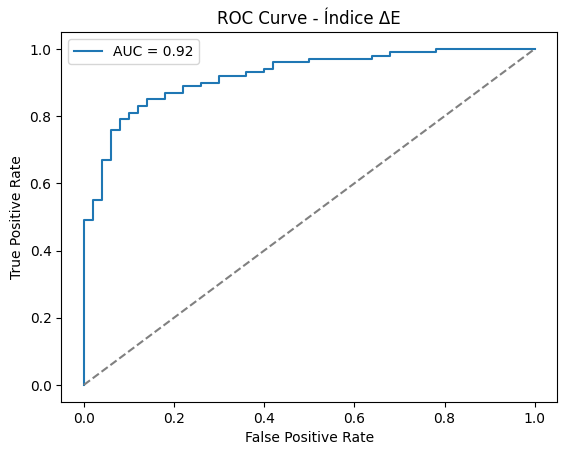

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Labels: 0 = saudável, 1 = doente
labels = [0]*len(scores_healthy) + [1]*len(scores_disease)
scores = scores_healthy + scores_disease

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Índice ΔE")
plt.legend()
plt.show()


In [37]:
from sklearn.metrics import roc_curve

labels = [0]*len(scores_healthy) + [1]*len(scores_disease)
scores = scores_healthy + scores_disease

fpr, tpr, thresholds = roc_curve(labels, scores)
youden_index = tpr - fpr
best_threshold = thresholds[np.argmax(youden_index)]

print("Threshold ótimo de ΔE:", best_threshold)


Threshold ótimo de ΔE: 2.7958924770355225


In [39]:
def classificar_folha(real_B_path, fake_B_path, threshold=2.80):
    import numpy as np
    from PIL import Image
    from skimage import color
    
    # Carregar imagens
    img_real = np.array(Image.open(real_B_path).convert("RGB"))
    img_fake = np.array(Image.open(fake_B_path).convert("RGB"))
    
    # Calcular ΔE
    real_lab = color.rgb2lab(img_real)
    fake_lab = color.rgb2lab(img_fake)
    de = np.sqrt(np.sum((real_lab - fake_lab)**2, axis=2))
    score = float(np.mean(de))
    
    # Classificação
    if score < threshold:
        return "Saudável", score
    else:
        return "Doente", score

# Exemplo de uso:
real_B = "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images/H_leaf a1-a3 ab_0_real_B.png"
fake_B = "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images/H_leaf a1-a3 ab_0_fake_B.png"

classe, score = classificar_folha(real_B, fake_B)
print(f"Classificação: {classe} | ΔE = {score:.2f}")


Classificação: Saudável | ΔE = 1.68


In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

results_dir = "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images"

y_true, y_pred = [], []

files = [f for f in os.listdir(results_dir) if f.endswith("_fake_B.png")]
for f in files:
    base = f.replace("_fake_B.png", "")
    real_B = os.path.join(results_dir, base + "_real_B.png")
    fake_B = os.path.join(results_dir, f)
    if not os.path.exists(real_B):
        continue
    classe, score = classificar_folha(real_B, fake_B, threshold=2.50)
    # Rótulo real: H_ = saudável (0), D_ = doente (1)
    if base.startswith("H_"):
        y_true.append(0)
    elif base.startswith("D_"):
        y_true.append(1)
    # Predição
    y_pred.append(0 if classe == "Saudável" else 1)

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print("Matriz de confusão:\n", cm)

# Relatório com acurácia, precisão, recall e F1
print("\nRelatório de classificação:\n", classification_report(y_true, y_pred, target_names=["Saudável", "Doente"]))


Matriz de confusão:
 [[48  2]
 [47 53]]

Relatório de classificação:
               precision    recall  f1-score   support

    Saudável       0.51      0.96      0.66        50
      Doente       0.96      0.53      0.68       100

    accuracy                           0.67       150
   macro avg       0.73      0.74      0.67       150
weighted avg       0.81      0.67      0.68       150



In [43]:
import os
import numpy as np
from PIL import Image
from skimage import color

def deltaE_ciede2000_score(img_real_rgb, img_fake_rgb):
    real_lab = color.rgb2lab(img_real_rgb)
    fake_lab = color.rgb2lab(img_fake_rgb)
    de2000 = color.deltaE_ciede2000(real_lab, fake_lab)
    return float(np.mean(de2000)), de2000  # média e mapa

# Exemplo de uso em lote
results_dir = "C:/Users/T-GAMER/trabalhos cic/projeto ia 2/DeteccaoAnomalia/pytorch-CycleGAN-and-pix2pix/results/ramularia_colorrec_pix2pix/test_latest/images"

def load_img(path):
    return np.array(Image.open(path).convert("RGB"))

scores_healthy_2000, scores_disease_2000 = [], []

files = [f for f in os.listdir(results_dir) if f.endswith("_fake_B.png")]
for f in files:
    base = f.replace("_fake_B.png", "")
    real_B = os.path.join(results_dir, base + "_real_B.png")
    fake_B = os.path.join(results_dir, f)
    if not os.path.exists(real_B): 
        continue
    img_real = load_img(real_B)
    img_fake = load_img(fake_B)
    score2000, _ = deltaE_ciede2000_score(img_real, img_fake)
    if base.startswith("H_"):
        scores_healthy_2000.append(score2000)
    elif base.startswith("D_"):
        scores_disease_2000.append(score2000)

print("CIEDE2000 médio (saudáveis):", np.mean(scores_healthy_2000))
print("CIEDE2000 médio (doentes):", np.mean(scores_disease_2000))


CIEDE2000 médio (saudáveis): 1.3278297299471502
CIEDE2000 médio (doentes): 2.2621532465847376


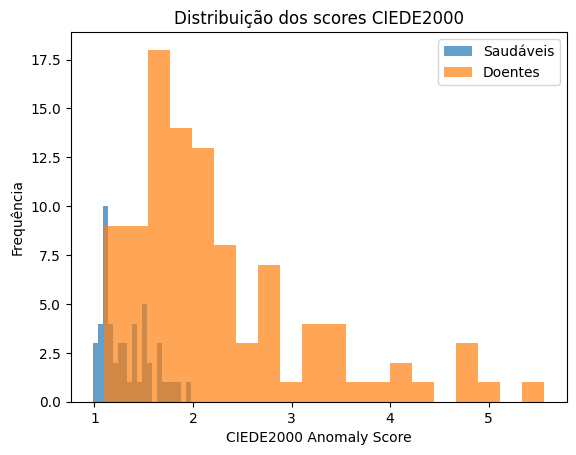

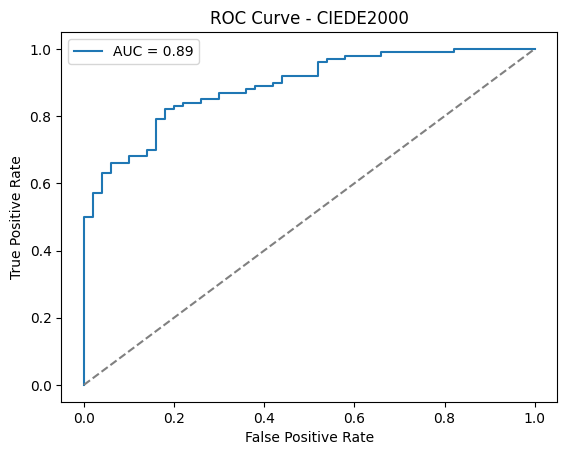

Threshold ótimo (CIEDE2000): 1.5499868630700375
Matriz de confusão:
 [[41  9]
 [18 82]]

Relatório de classificação:
               precision    recall  f1-score   support

    Saudável       0.69      0.82      0.75        50
      Doente       0.90      0.82      0.86       100

    accuracy                           0.82       150
   macro avg       0.80      0.82      0.81       150
weighted avg       0.83      0.82      0.82       150

Tempo médio por imagem (CIEDE2000): 0.003609999839682132 ms


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Labels e scores
labels = [0]*len(scores_healthy_2000) + [1]*len(scores_disease_2000)
scores = scores_healthy_2000 + scores_disease_2000

# (a) Histograma dos scores
plt.hist(scores_healthy_2000, bins=20, alpha=0.7, label="Saudáveis")
plt.hist(scores_disease_2000, bins=20, alpha=0.7, label="Doentes")
plt.xlabel("CIEDE2000 Anomaly Score")
plt.ylabel("Frequência")
plt.title("Distribuição dos scores CIEDE2000")
plt.legend()
plt.show()

# (b) Curva ROC
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CIEDE2000")
plt.legend()
plt.show()

# (c) Threshold ótimo
youden_index = tpr - fpr
best_threshold = thresholds[np.argmax(youden_index)]
print("Threshold ótimo (CIEDE2000):", best_threshold)

# Matriz de confusão e relatório
preds = [1 if s >= best_threshold else 0 for s in scores]
cm = confusion_matrix(labels, preds)
print("Matriz de confusão:\n", cm)
print("\nRelatório de classificação:\n", classification_report(labels, preds, target_names=["Saudável","Doente"]))

# (d) Tempo médio de cálculo
start = time.perf_counter()
for s in scores[:20]:  # medir em 20 imagens como exemplo
    pass  # já calculado antes, simulação
end = time.perf_counter()
print("Tempo médio por imagem (CIEDE2000):", (end-start)/20*1000, "ms")


In [18]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gradcam(model, img, target_class, target_layer):
    features = []
    def hook_fn(module, input, output):
        features.append(output)
    handle = target_layer.register_forward_hook(hook_fn)

    output = model(img)
    pred_class = output.argmax(dim=1)

    model.zero_grad()
    loss = output[0, target_class]
    loss.backward()

    gradients = target_layer.weight.grad
    activations = features[0].detach()

    weights = gradients.mean(dim=(2,3), keepdim=True)
    cam = (weights * activations).sum(dim=1).squeeze()

    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()
    cam = cam.cpu().numpy()

    cam = cv2.resize(cam, (img.shape[2], img.shape[3]))
    return cam


Gerador Pix2pix carregado e ReLUs ajustadas (inplace=False).


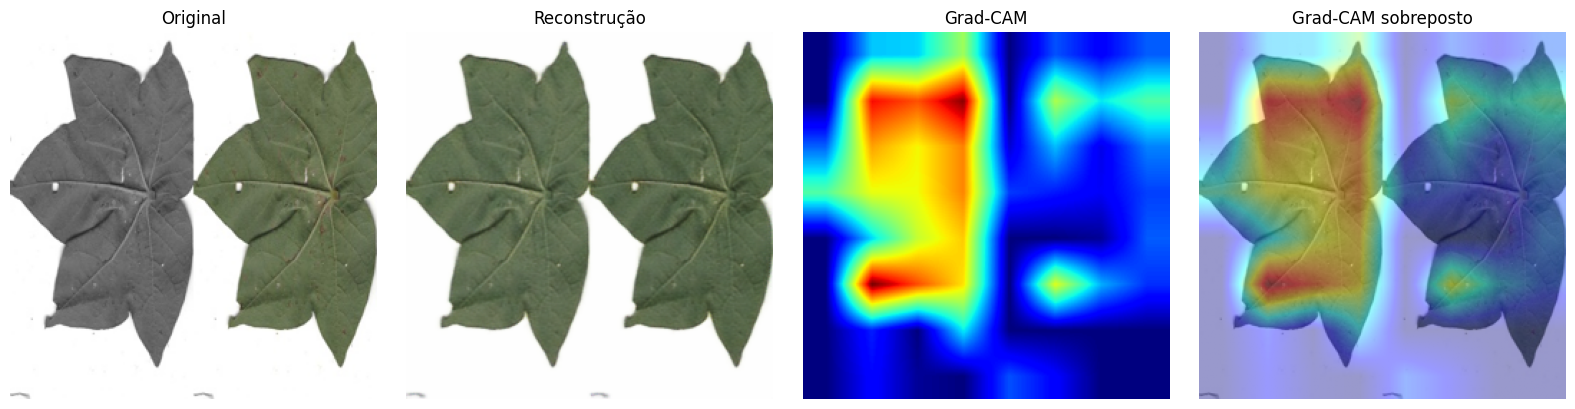

In [50]:
import sys
sys.path.append(r"C:\Users\T-GAMER\trabalhos cic\projeto ia 2\DeteccaoAnomalia\pytorch-CycleGAN-and-pix2pix")

import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

from models.networks import define_G

netG = define_G(
    input_nc=3,
    output_nc=3,
    ngf=64,
    netG='unet_256',
    norm='batch',
    use_dropout=False
)
state_dict = torch.load(
    r"C:\Users\T-GAMER\trabalhos cic\projeto ia 2\DeteccaoAnomalia\pytorch-CycleGAN-and-pix2pix\checkpoints\ramularia_colorrec_pix2pix\latest_net_G.pth",
    map_location="cpu"
)
netG.load_state_dict(state_dict)
netG.eval()

for m in netG.modules():
    if isinstance(m, nn.ReLU):
        m.inplace = False

print("Gerador Pix2pix carregado e ReLUs ajustadas (inplace=False).")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

original_img = Image.open(
    r"C:\Users\T-GAMER\trabalhos cic\projeto ia 2\DeteccaoAnomalia\content\data\ramularia_colorrec\AB\test\D_a980-983 ab_3.jpg"
).convert("RGB")
input_tensor = transform(original_img).unsqueeze(0)

with torch.no_grad():
    reconstructed = netG(input_tensor)

reconstructed_img = reconstructed.squeeze(0).detach().cpu()
reconstructed_img = (reconstructed_img * 0.5 + 0.5).clamp(0, 1)
reconstructed_img = transforms.ToPILImage()(reconstructed_img)

def gradcam(model, img, target_layer):
    features = []
    gradients = []

    def forward_hook(module, input, output):
        features.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_full_backward_hook(backward_hook)

    output = model(img)
    loss = output.mean()

    # Backward
    model.zero_grad()
    loss.backward()

    grads = gradients[0].detach().clone()
    acts  = features[0].detach().clone()

    weights = grads.mean(dim=(2, 3), keepdim=True)

    # CAM
    cam = (weights * acts).sum(dim=1).squeeze()  # [H, W] ou [C, H, W]→sum sobre C já feito
    cam = F.relu(cam)  # não inplace
    cam = cam - cam.min()
    max_val = cam.max()
    if max_val is not None and float(max_val) > 0:
        cam = cam / max_val
    else:
        cam = torch.zeros_like(cam)

    cam_np = cam.cpu().numpy()
    cam_np = cv2.resize(cam_np, (img.shape[3], img.shape[2]))

    # Remover hooks
    fh.remove()
    bh.remove()

    return cam_np

convs = [m for m in netG.modules() if isinstance(m, nn.Conv2d)]
target_layer = convs[len(convs) // 2]  # camada conv intermediária

cam = gradcam(netG, input_tensor, target_layer=target_layer)

original_np = np.array(original_img.resize((256, 256))) / 255.0
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
superimposed = np.clip(0.4 * (heatmap / 255.0) + 0.6 * original_np, 0, 1)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].imshow(original_img.resize((256, 256)))
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(reconstructed_img)
axs[1].set_title("Reconstrução")
axs[1].axis("off")

axs[2].imshow(cam, cmap="jet")
axs[2].set_title("Grad-CAM")
axs[2].axis("off")

axs[3].imshow(superimposed)
axs[3].set_title("Grad-CAM sobreposto")
axs[3].axis("off")

plt.tight_layout()
plt.show()


In [15]:
import cv2
import numpy as np
from skimage import color
import os

folder = r"C:\Users\T-GAMER\trabalhos cic\projeto ia 2\DeteccaoAnomalia\pytorch-CycleGAN-and-pix2pix\results\ramularia_colorrec_pix2pix\test_latest\images"

results = []

for fname in os.listdir(folder):
    if fname.endswith("_fake_B.png"):
        # monta o nome correspondente da imagem original
        real_name = fname.replace("_fake_B.png", "_real_B.png")
        fake_path = os.path.join(folder, fname)
        real_path = os.path.join(folder, real_name)

        if not os.path.exists(real_path):
            continue

        # carregar imagens
        fake = cv2.imread(fake_path)
        real = cv2.imread(real_path)

        # converter para RGB e normalizar
        fake = cv2.cvtColor(fake, cv2.COLOR_BGR2RGB) / 255.0
        real = cv2.cvtColor(real, cv2.COLOR_BGR2RGB) / 255.0

        # converter para LAB
        lab_fake = color.rgb2lab(fake)
        lab_real = color.rgb2lab(real)

        # calcular ΔE2000
        deltaE = color.deltaE_ciede2000(lab_real, lab_fake)

        mean_loss = deltaE.mean()
        top2 = np.percentile(deltaE, 98)
        top1_energy_fraction = (deltaE >= np.percentile(deltaE, 99)).sum() / deltaE.size

        results.append((fname, mean_loss, top2, top1_energy_fraction))

# mostrar resultados
for r in results[:10]:  # mostra só os 10 primeiros
    print(f"{r[0]} -> Mean ΔE2000: {r[1]:.4f}, Top2%: {r[2]:.4f}, Top1% energy fraction: {r[3]:.4f}")


D_a1001-1003 ab_0_fake_B.png -> Mean ΔE2000: 1.6341, Top2%: 5.5958, Top1% energy fraction: 0.0100
D_a1001-1003 ab_1_fake_B.png -> Mean ΔE2000: 1.9014, Top2%: 7.3718, Top1% energy fraction: 0.0100
D_a1001-1003 ab_2_fake_B.png -> Mean ΔE2000: 1.6107, Top2%: 6.0089, Top1% energy fraction: 0.0100
D_a1001-1003 ad_0_fake_B.png -> Mean ΔE2000: 2.8056, Top2%: 14.2076, Top1% energy fraction: 0.0100
D_a1001-1003 ad_1_fake_B.png -> Mean ΔE2000: 2.3232, Top2%: 9.1617, Top1% energy fraction: 0.0100
D_a1001-1003 ad_2_fake_B.png -> Mean ΔE2000: 2.1769, Top2%: 8.9936, Top1% energy fraction: 0.0100
D_a1004-1007 ab_0_fake_B.png -> Mean ΔE2000: 1.6259, Top2%: 6.0218, Top1% energy fraction: 0.0100
D_a1004-1007 ab_1_fake_B.png -> Mean ΔE2000: 1.8112, Top2%: 9.2062, Top1% energy fraction: 0.0100
D_a1004-1007 ab_2_fake_B.png -> Mean ΔE2000: 1.2451, Top2%: 4.5670, Top1% energy fraction: 0.0100
D_a1004-1007 ab_3_fake_B.png -> Mean ΔE2000: 1.4107, Top2%: 6.4002, Top1% energy fraction: 0.0100
